In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

from ase.io import read
from pyqstem.util import atoms_plot
from pyqstem import PyQSTEM
from pyqstem.potentials import create_potential_slices

from potentials import ParameterizedPotential
from utils import kappa

from gpaw import GPAW, PW
from gpaw.utilities.ps2ae import PS2AE

## Potentials

In [4]:
atoms = read('graphene.cif', index = 0)
calc = GPAW(mode=PW(600), eigensolver = 'cg', h=.1)
atoms.set_calculator(calc)
atoms.get_potential_energy()

In [2]:
ps2ae = PS2AE(atoms.calc, h=0.025)
v_dft = -ps2ae.get_electrostatic_potential(ae=True)
v_dft = v_dft - np.mean(v_dft)

#v_dft = np.load('potential.npy')

In [5]:
grid = v_dft.shape
lobato = ParameterizedPotential('gpaw', atoms, grid)
v = lobato.calc_from_splines()
v = v - np.mean(v)

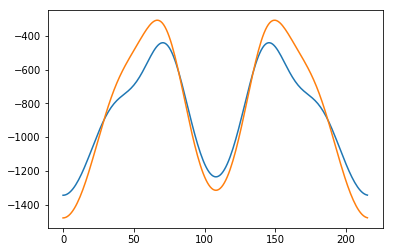

In [6]:
plt.plot(np.sum(v_dft,axis=2)[60])
plt.plot(np.sum(v,axis=2)[60])

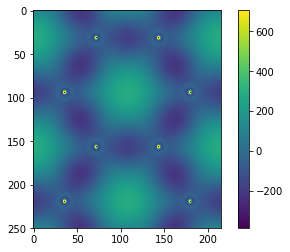

In [7]:
plt.imshow(np.sum(v_dft,axis=2)-np.sum(v,axis=2))
plt.colorbar()

## Images

In [9]:
v_sliced = create_potential_slices(v * kappa, 60, np.diag(atoms.cell)) # multiplying by kappa converts to QSTEM units
v_dft_sliced = create_potential_slices(v_dft * kappa, 60, np.diag(atoms.cell))

In [10]:
qstem=PyQSTEM('TEM')
qstem.set_atoms(atoms)
qstem.build_wave('plane', 80, v_dft.shape[:2])
# qstem.build_potential(10)
# v_qstem=qstem.get_potential_or_transfunc()
qstem.set_potential(v_dft_sliced)
qstem.run()
wave_dft=qstem.get_wave()

qstem.build_wave('plane', 80, v.shape[:2])
qstem.set_potential(v_sliced)
qstem.run()
wave_param=qstem.get_wave()

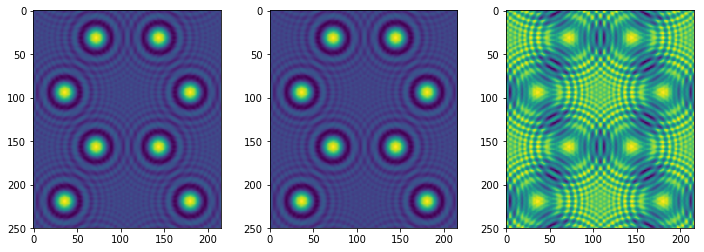

In [11]:
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(12,4))
ax1.imshow(wave_dft.detect())
ax2.imshow(wave_param.detect())
ax3.imshow((wave_dft.detect()-wave_param.detect())/wave_param.detect())